In [1]:
import nibabel as nib
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
base_dir = '/home/fhd/projects/.DATASETS/HealthyControls/'
ind_dir = os.path.join(base_dir,'C01')
rec_path = os.path.join(ind_dir,'left_foot_trial_21.nii')

2022-01-19 18:16:15.155871: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-19 18:16:15.155940: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def read_single(img_path:str) -> np.memmap:
    '''function that gets the path of a single record and returns the memmap array in shape of (36,20,:)'''
    img = nib.load(img_path)
    try:
        data = img.get_fdata()
        if not (data.shape[1] <20 or data.shape[0] < 35):
            return img.get_fdata()[:35,:20,:]
    except :
        return None

def read_all(all_path:list) -> pd.DataFrame:
    '''get list of paths and returns of Y memmap of all records shape of (36,20,:)'''
    Y = np.zeros((35,20,0)) # initiating Y 
    #reading all images
    for path in all_path:
        arr = read_single(os.path.join(ind_dir,path))
        if type(arr)==np.memmap: Y = np.append(Y,arr,axis=2) #appending to Y
    return Y
    
def preprocess(memmap:np.memmap) -> pd.DataFrame:
    memmap = memmap.reshape(-1, memmap.shape[-1])
    return pd.DataFrame(memmap).T

def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(10,)))
    model.add(tf.keras.layers.Dense(16,activation='relu'))
    model.add(tf.keras.layers.Dense(32,activation='relu'))
    model.add(tf.keras.layers.Dense(64,activation='relu'))
    model.add(tf.keras.layers.Dense(128,activation='relu'))
    model.add(tf.keras.layers.Dense(256,activation='relu'))
    model.add(tf.keras.layers.Dense(512,activation='relu'))
    model.add(tf.keras.layers.Dense(700,activation='linear'))
    model.compile(optimizer='adam', loss='mse',metrics=['MeanSquaredError',])
    return model

def get_all_path( Left:bool =True, ex=None,inc=None) -> list:
    '''if you want the left foot then put True else Flase, parameter ex excludes from output'''
    all_path=[]
    for folder in list(os.walk(base_dir)):
        for filename in folder[2]:
            if Left:
                if 'left' in filename:
                    all_path.append(os.path.join(folder[0],filename))
            else:
                if 'right' in filename:
                    all_path.append(os.path.join(folder[0],filename))
    if ex: all_path= list(filter(lambda x: ex not in x,all_path))
    elif inc: all_path= list(filter(lambda x: inc in x,all_path))
    return all_path

def animate(result,name):
    import matplotlib.pyplot as plt
    from celluloid import Camera
    fig = plt.figure(figsize=(3,6))
    camera = Camera(fig)
    for i in range (result.shape[2]):
        plt.contourf(result[:,:,i],cmap='Reds')
        plt.title(i)
        if i:
            camera.snap()
    animation = camera.animate()
    animation.save(os.path.join('output',name),fps=70)

def convert_2dIndex_to_1d(index):
    shape = (35,20)
    x,y = index
    _,Y = shape
    return x*Y+y
        

In [16]:
#making Y dataset
all_path = get_all_path(ex='C31')
Y = read_all(all_path)
Y = preprocess(Y)

In [20]:
#making X dataset
selected_nodes_2d =[(14,4),(11,4),(5,21),(3,22),(10,27),(7,32),(6,30),(9,32),(12,27),(6,23)]
selected_nodes_1d = list(map(convert_2dIndex_to_1d,selected_nodes_2d))
X = Y[selected_nodes_1d]

In [21]:
# Splitting datasets
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, shuffle =False)

In [22]:
model = create_model()

2022-01-19 14:15:18.437979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-19 14:15:18.438282: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-19 14:15:18.438588: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Fhd): /proc/driver/nvidia/version does not exist
2022-01-19 14:15:18.443870: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
model.fit(
    x=X_train, y=y_train, batch_size=64, epochs=5,
    validation_split=0.2, validation_data=None, shuffle=True,
    workers=2, use_multiprocessing=True
)

2022-01-19 14:15:46.301999: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 916860000 exceeds 10% of free system memory.


Epoch 1/5
2559/2559 [==============================] - ETA: 0s - loss: 19.3886 - mean_squared_error: 19.3886

2022-01-19 14:16:00.559989: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 229219200 exceeds 10% of free system memory.


2559/2559 [==============================] - 15s 5ms/step - loss: 19.3886 - mean_squared_error: 19.3886 - val_loss: 19.4824 - val_mean_squared_error: 19.4824
Epoch 2/5
2559/2559 [==============================] - 12s 5ms/step - loss: 18.5366 - mean_squared_error: 18.5366 - val_loss: 19.6606 - val_mean_squared_error: 19.6606
Epoch 3/5
2559/2559 [==============================] - 12s 5ms/step - loss: 18.3731 - mean_squared_error: 18.3731 - val_loss: 19.7185 - val_mean_squared_error: 19.7185
Epoch 4/5
2559/2559 [==============================] - 12s 5ms/step - loss: 18.2188 - mean_squared_error: 18.2188 - val_loss: 20.0326 - val_mean_squared_error: 20.0326
Epoch 5/5
2559/2559 [==============================] - 12s 5ms/step - loss: 18.0897 - mean_squared_error: 18.0897 - val_loss: 19.6809 - val_mean_squared_error: 19.6809


In [29]:
#making plot dataset
test_path = get_all_path(inc='C31')
Yplot = read_all(test_path)
Yplot = preprocess(Yplot)
Xplot = Yplot[selected_nodes_1d]

In [30]:
results = model.predict(Xplot)

In [32]:
result = results.T
result = result.reshape(35,20,result.shape[-1])

In [6]:
animate(result[:,:,:350],'model-10input-first350-epoch5-fps70.gif')

NameError: name 'result' is not defined

In [3]:
test_path = get_all_path(inc='C31')
Yplot = read_all(test_path)

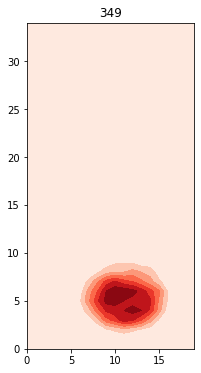

In [5]:
animate(Yplot[:,:,:350],'grandTruth-C031-first350-fps70.gif')